# Installation notes
MediaPipe is only supported up to Python3.11 (newest stable is 3.12 and 3.13 beta is avaliable).  You need to install Python3.11 to be able to use mediapipe

In Anaconda, you can create a new pyenv and use this to install the older python version.  Then (pip) install mediapipe and opencv-python under this version.  When running in VS-Code, make sure the correct python Kernel is being used  

In [1]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

# Code for hand recognition
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands= mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task
#  off-the-shelf model. This model can recognize 7 hand gestures: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟

global gesture_result
gesture_result = None

# In LIVE_STREAM mode, MediaPipe requires a result_callback function.  It is supposed to be optional, 
# but if you don't supply it, then it crashes, so it might be a bug.  In LIVE_STREAM, there doesn't seem to be a way to grab the gesture back
#  and the mp.Image is not the same as the frame that is latter being draw.  So my hack was to use global variables to return the gesture label back 
# and then use cv2.PutText to add it to the frame for display

# Create a gesture recognizer instance with the live stream mode:
def print_result(result:vision.GestureRecognizerResult, output_image: mp.Image, timestamp_ms: int):
    global gesture_result
    if(result.gestures):
        gs=result.gestures[0][0]  
        if(not gs.category_name=='None'):
            gesture_result=gs.category_name
            #print(gesture_result)
        else:
            gesture_result=None


# Code for gesture recognition
options = vision.GestureRecognizerOptions(
    base_options= python.BaseOptions(model_asset_path='gesture_recognizer.task'),
    running_mode=mp.tasks.vision.RunningMode.LIVE_STREAM,
    result_callback=print_result)

recognizer = vision.GestureRecognizer.create_from_options(options)

# Initialize the webcam
cap = cv2.VideoCapture(0)

I0000 00:00:1731363025.177440  778474 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-20.7.3), renderer: Intel(R) Iris(TM) Plus Graphics 640
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1731363025.212765  778474 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-20.7.3), renderer: Intel(R) Iris(TM) Plus Graphics 640
W0000 00:00:1731363025.221867  778474 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1731363025.240688  778474 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.
W0000 00:00:1731363025.257302  784797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731363025.302836  784797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:

In [2]:
fps = cap.get(cv2.CAP_PROP_FPS)
frame_timestamp_ms = 0.0


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Flip the image horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)
    
    frame_timestamp_ms+=(1000.0/fps)
    

    # Convert the BGR image to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe Hands
    # This is the command to actually find the hands in the imagee
    hands_results = hands.process(image)
    
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    recognizer.recognize_async(mp_image,np.int64(frame_timestamp_ms))
    
    if(gesture_result is not None):
        cv2.putText(frame,gesture_result,(10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Draw the hand landmarks on the image
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            # If we found hands, then use the mediaPipe's drawing code to add the landmarks on to our image for display
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    
    # Display the resulting image
    cv2.imshow('MediaPipe Hands', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

W0000 00:00:1731363026.789270  784796 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


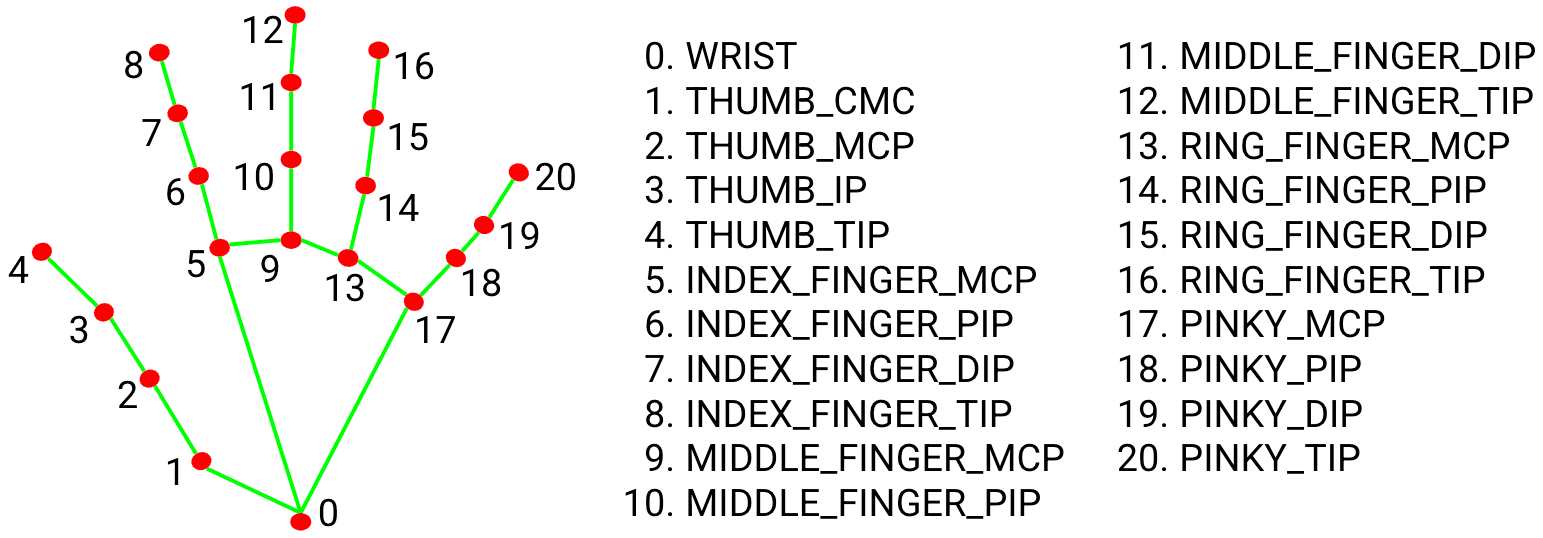

In [ ]:
# This tells me which hand(s) are found and their index
print(hands_results.multi_handedness)

hand=hands_results.multi_hand_world_landmarks[0]

# I can then grab the specific landmarks like this:
# hand.landmark[4]

# or to get the vector between points
thumb_to_index=np.array((hand.landmark[4].x-hand.landmark[8].x,hand.landmark[4].y-hand.landmark[8].y,hand.landmark[4].z-hand.landmark[8].z))

print("Distance from tip of thumb to index finger is " + str(round(np.sqrt(np.sum(thumb_to_index**2))*100,2)) + ' cm')


In [ ]:
# this is the graph used to define the hand connections
mp_hands.HAND_CONNECTIONS

frozenset({(0, 1),
           (0, 5),
           (0, 17),
           (1, 2),
           (2, 3),
           (3, 4),
           (5, 6),
           (5, 9),
           (6, 7),
           (7, 8),
           (9, 10),
           (9, 13),
           (10, 11),
           (11, 12),
           (13, 14),
           (13, 17),
           (14, 15),
           (15, 16),
           (17, 18),
           (18, 19),
           (19, 20)})